# 08. 포아송 과정

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

<br>

## 08.01 월드컵 문제

> 2018 FIFA 월드컵 결승전에서, 프랑스는 크로아티아에게 4대 2로 이겼다. 이 결과에 대하여
> 
> 1. 프랑스가 크로아티아보다 더 나은 팀일 가능성은 어느 정도일까?
> 
> 2. 만약 같은 팀이 다시 경기를 한다면, 프랑스가 다시 이길 확률은?

<br>

이 질문에 대하여
- **어떤 팀이든 다른 팀과 경기를 할 때 있어서 경기당 몇 개의 골을 넣을 것인지에 대한 임의의 득점율. $\lambda$**
* **공이 골에 들어갈 확률은 경기 내내 동일한다고 가정. 90분 경기에서 매분마다 득점 확률은 $\lambda /90$**
* **한 팀에서는 일분 내에 2점을 내지 않는다는 가정**

<br>

- **이 가정에 따르면, 경기에서 공이 골에 들어갈 횟수는 대략적으로 포아송분포를 따를 것**

    - 이 3가지의 가정은 임의적이고 단순화된 과정


<br>

## 08.02. 포아송분포

**한 경기에서 골에 들어간 공의 수가 득점률 $\lambda$ 인 포아송분포를 따른다고 하면, $k$점을 얻을 확률은 모든 양수 $k$에 대하여**

$$\lambda^k \exp(-\lambda) ~/~ k!$$

<br>

#### `scipy.stats.poisson(lam)` : $\lambda$가 `lam`인 포아송분포의 확률분포함수

In [9]:
from scipy.stats import poisson

In [10]:
lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

- **경기당 득점률이 1.4인 경우, 한 경기에서 4점을 득점할 화률은 약 4%**

In [11]:
k = 4
dist.pmf(k)

0.039471954028253146

<br>

- $\lambda=4$인 포아송분포의 $x=0 \sim 9$일 때의 확률분포함수 값

In [14]:
from empiricaldist import Pmf
import numpy as np

In [15]:
def make_poisson_pmf(lam, qs):

    """포아송분포를 나타내는 Pmf를 생성"""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    
    return pmf

In [16]:
lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

In [21]:
pmf_goals

,probs
0,0.246598
1,0.345237
2,0.241666
3,0.112777
4,0.039472
5,0.011052
6,0.002579
7,0.000516
8,0.000090
9,0.000014


In [18]:
from utils import decorate

In [19]:
def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)

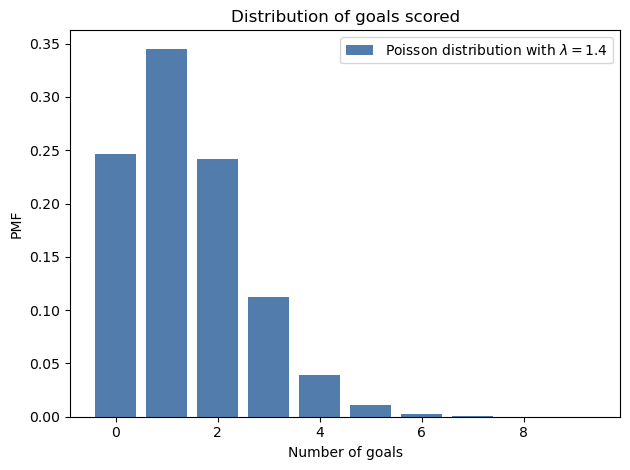

In [20]:
pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')

decorate_goals('Distribution of goals scored')

#### $\lambda=4$인 포아송분포에서 확률분포함수값이 가장 높은 값은 $x=0, 1, 2$

<br>

## 08.03. 감마분포

- 많은 경기에서, 양 팀의 득점수는 대부분 10점을 넘어가는 경우는 거의 없음
- 강한 팀과 약한 팀이 붙었을 경우, 득점의 분포는 $\lambda$가 더 높은 포아송분포를 따를 것

    약한 팀이 강한 팀과 붙었을 경우, 득점의 분포는 $\lambda$가 더 낮은 포아송분포를 따를 것

<br>

#### 득점율의 분포를 모델링하기 위하여 감마분포를 사용하는 이유

> **1. 득점율은 연속형이고 0 이상의 수이므로, 감마분포가 이 범위의 값에 더 적합**
> 
> **2. 감마분포는 평균값 $\alpha$만을 매개변수로 사용하므로, 평균값만으로 원하는 감마분포를 만들기가 용이**
>

<br>

#### `scipy.stats.gamma(alpha)` : $\alpha$를 평균으로 가지는 감마분포의 확률분포함수 생성

In [30]:
from scipy.stats import gamma
from empiricaldist import Pmf

#### **$\alpha$가 1.4일 때, $\lambda$값 0 ~ 10에서의 확률밀도함수**

In [68]:
alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

prior = Pmf(ps, qs)
prior.normalize()

9.889360237140306

In [48]:
prior.mean()

1.4140818156118378

In [46]:
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

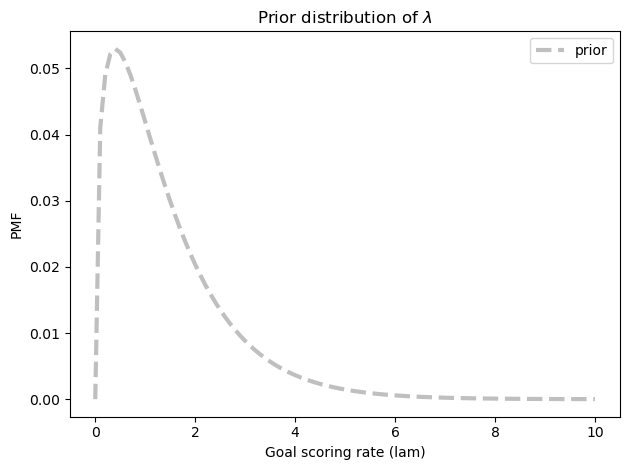

In [47]:
prior.plot(ls='--', label='prior', color='C5')
decorate_rate(r'Prior distribution of $\lambda$')

<br>

## 08.04. 베이지안 갱신


<br>


#### **사전분포가 모수가 $\lambda$를 가지는 포아송분포이고, 관측값이 주어졌을 때**

#### **사전분포 모수에 대한 확률분포함수(감마분포) 값을 통하여 가능도계산**

#### **가능도를 통하여 사전분포를 사후분포로 갱신**

<hr>

<br>

#### **득점률 $\lambda$가 주어졌을 때,$k$만큼 득점할 확률을 구하는 경우, 포아송분포의 PMF를 활용**


**사전분포가 $\lambda=1.4$을 가지는 포아송 분포일때, 경기에서 4점을 만들 확률은**

In [49]:
lam = 1.4
k = 4
poisson(lam).pmf(4)

0.039471954028253146

<br>

**$\lambda$가, 0 ~ 10의 범위에서, $\alpha=1.4$를 가지는  감마분포를 따를때,** 

**경기에서 4점을 만든 경우에 대한 가능도**

In [75]:
alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

prior = Pmf(ps, qs)
prior.normalize()
prior.head()

,probs
0.0,0.000000
0.1,0.041053
0.2,0.049015


In [70]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

<br>

#### 사전확률에 구한 가능도를 곱한 후 정규화 $\rightarrow$ 사후확률분포

<br>

- **프랑스가 4점을 냈을 때의 사후확률분포**
    - $\lambda$가 더 큰 값을 가질 가능성이 높고, 더 낮은 값을 가능성이 낮다고 보여짐 $\rightarrow$ 사후분포가 더 오른쪽으로 옮겨짐

In [82]:
def update_poisson(pmf, data):
    
    """포아송 가능도로 PMF를 갱신"""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

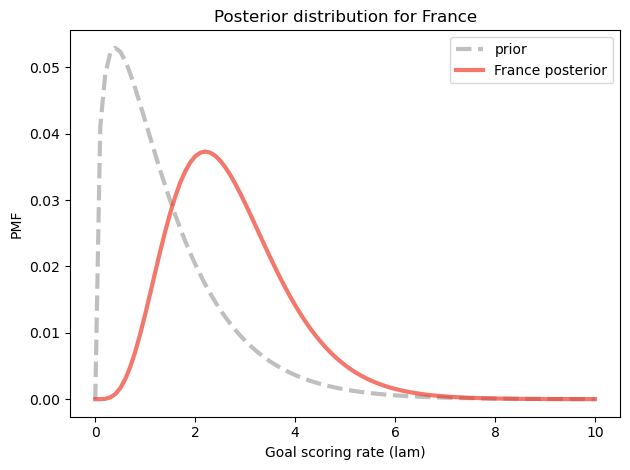

In [128]:
france = prior.copy()
update_poisson(france, 4)

prior.plot(ls='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

decorate_rate('Posterior distribution for France')

<br>

- **크로아티아가 2점을 득점했을 때의 사후분포**

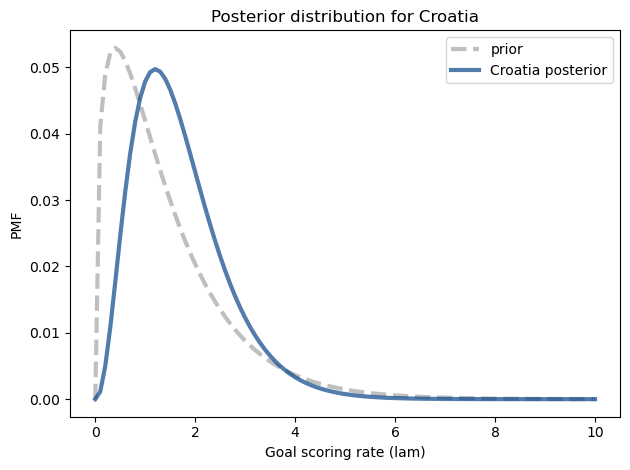

In [127]:
croatia = prior.copy()
update_poisson(croatia, 2)

prior.plot(ls='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')

decorate_rate('Posterior distribution for Croatia')

<br>

### 베이지안 갱신
- **사전분포의 평균은 약 1.4**
    - 크로아티아가 2골을 넣음 $\rightarrow$ 베이지안 갱신 $\rightarrow$  사후확률의 평균은 1.7
    - 프랑스가 4골을 넣음  $\rightarrow$ 베이지안 갱신 $\rightarrow$  사후확률의 평균은 2.7

<br>

#### 사후분포는 사전분포와 데이터 간의 정중앙 어딘가에 위치

In [87]:
print(croatia.mean(), france.mean())

1.6999765866755225 2.699772393342308


<br>

## 08.05. 우세할 확률

> **그렇다면 프랑스가 더 나은 팀일 확률은? (= 상대팀보다 득점율이 더 높을 확률)**
> 
> **$\rightarrow$ 프랑스의 사후분포에서 임의로 선택한 값이, 크로아티아의 사후분포에서 임의로 선택한 값보다 더 클 확률**

<hr>

<br>


#### 두 사후분포의 모든 값의 쌍을 나열한 후, 한 값이 다른 값보다 클 확률을 모두 더함
- 결과는 약 75% $\rightarrow$ 한 경기를 기반으로 했을 때는 프랑스가 실제로 더 나은 팀일 가능성이 존재

<br>

#### `Pmf.prob_gt(pmf1, pmf2)` : 확률분포함수 `pmf1`의 값이 `pmf2`의 값보다 클 확률을 모두 더함

<br>

#### `Pmf.prob_lt(pmf1, pmf2)` : 확률분포함수 `pmf2`의 값이 `pmf1`의 값보다 클 확률을 모두 더함

<br>

#### `Pmf.prob_eq(pmf1, pmf2)` : 확률분포함수 `pmf1`의 값이 `pmf2`의 값과 동일할 확률을 모두 더함

In [133]:
Pmf.prob_gt(france, croatia)

0.7499366290930174

<br>

## 08.06. 다음 경기 예측

> **만약 경기를 다시 한다면,  크로아티아가 이길 확률은?**
>
> **$\rightarrow$ 한 팀이 얻을 점수에 대한 사후예측분포가 필요**

<br>

#### **득점율 $\lambda$를 안다면, 점수에 대한 사전분포는 $\lambda$를 가지는 포아송분포를 따름**
#### **하지만 $\lambda$를 모르는 상태에서, 점수에 대한 사후예측분포는 $\lambda$의 여러 값에 대한 포아송 분포의 혼합이 됨**

<br>

- **가능한 $\lambda$값 들 (0 ~ 10 사이 101개 값)에 대한 포아송분포**

In [134]:
prior.qs

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [135]:
goals

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [136]:
pmf_seq = [make_poisson_pmf(lam, goals) for lam in prior.qs]
pd.DataFrame(pmf_seq).shape

(101, 10)

In [137]:
import matplotlib.pyplot as plt
import pandas as pd

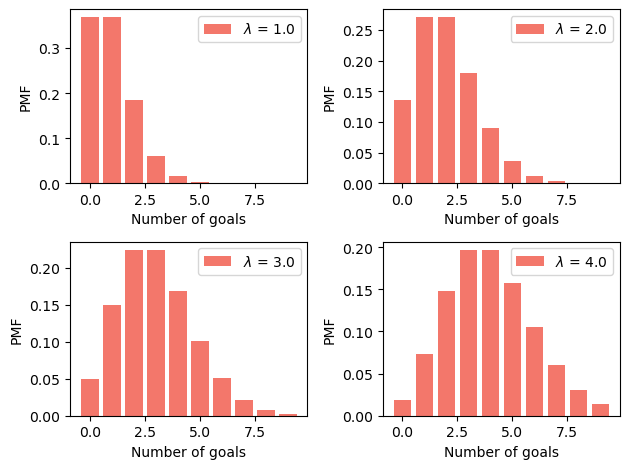

In [138]:
for i, index in enumerate([10, 20, 30, 40]):

    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    decorate_goals()

<br>

**사후예측분포는 이전에 구한 사후분포와, 101개의 가능한 $\lambda$값에 대한 101개의 분포에 대한 혼합분포**

In [139]:
def make_mixture(pmf, pmf_seq):
    
    """혼합분포 생성"""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    
    return Pmf(total)

- 재경기를 하는 경우 프랑스의 득점에 대한 예측분포

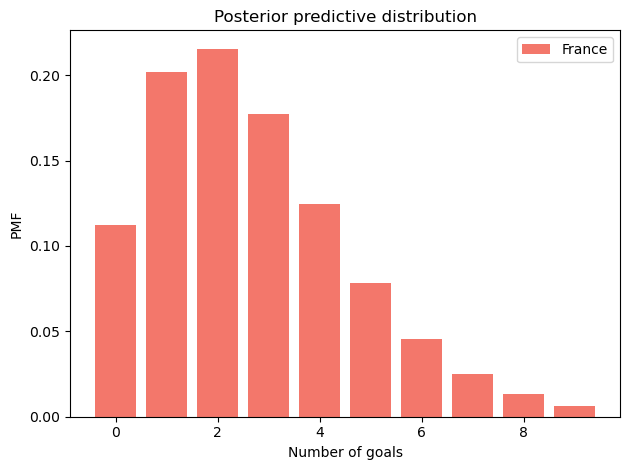

In [140]:
pred_france = make_mixture(france, pmf_seq)

pred_france.bar(color='C3', label='France')
decorate_goals('Posterior predictive distribution')

<br>

- 재경기를 하는 경우 크로아티아 득점에 대한 예측분포

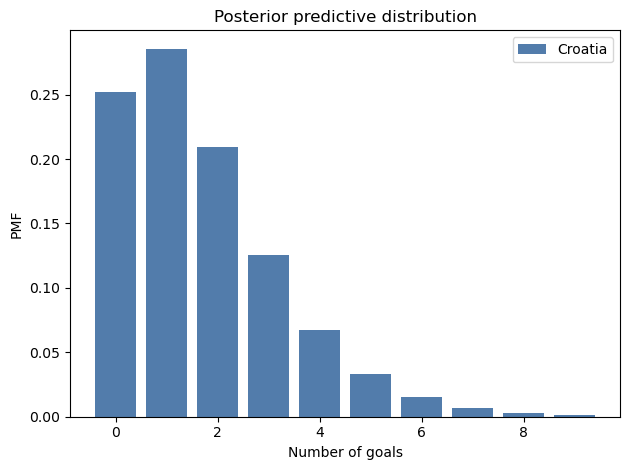

In [141]:
pred_croatia = make_mixture(croatia, pmf_seq)

pred_croatia.bar(color='C0', label='Croatia')
decorate_goals('Posterior predictive distribution')

<br>

#### 이 2개의 사후예측분포를 통하여, 재경기에서 프랑스가 이기거나 비기거나 질 확률을 계산

In [142]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934519

In [143]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26443376257235873

In [144]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418947

In [145]:
win + lose + tie

1.0

<br>

## 08.07 지수분포

> 2014 FIFA 월드컵에서, 독일은 브라질과의 준결승에서 11분과 23분에 한 번씩의 득점을 기록
> 
> 90분 후 독일은 몇 점을 냈을까?
>
> 5개의 골이 더 들어갈 확률은?

<br>

#### 사건의 시간 간격 $\sim$ 지수분포
- **득점율이 $\lambda$라면, 득점 간격 $t$는 지수분포의 확률밀도함수에 비레**
$$\lambda \exp(-\lambda t)$$



In [147]:
def expo_pdf(t, lam):

    """지수분포의 확률밀도함수를 계산"""
    return lam * np.exp(-lam * t)

<br>

- **$\lambda$가 1.4일 때, $t$의 분포**

In [154]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)

pmf_time = Pmf(ps, qs)
pmf_time.normalize()

pmf_time.head()

,probs
0.00,0.054652
0.04,0.051676
0.08,0.048861


In [149]:
def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

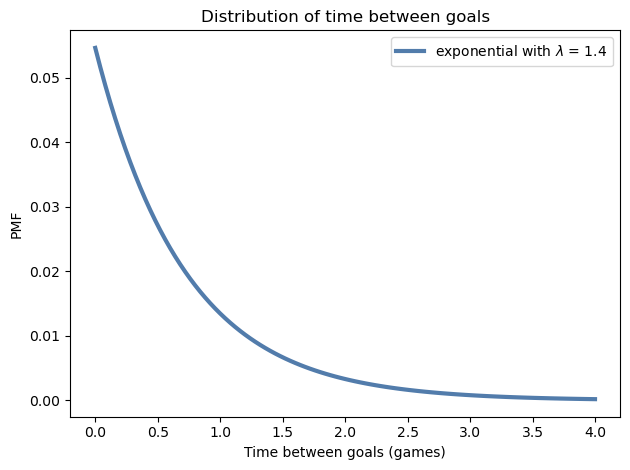

In [150]:
pmf_time.plot(label='exponential with $\lambda$ = 1.4')

decorate_time('Distribution of time between goals')